# CE7454 Project: Movie Rateing and Box-office Prediction

*Group 26: Li Jie, Shen Meng, Wang Ruihang*

Welcome to the our project! In this work, we are going to save the viewers and producers from the ocean of movies. Our job is to give a reliable prediction of a movies's rating and box-office before its theatrical release, aiming to offer useful information in an early stage. 

**In this project, we will:**
- Crawl and build our dataset from [IMDB](https://www.imdb.com)
- Clean and present the raw data for analysis
- Apply different models for movie rating and box-office prediction
- Propose our new architecture for further improvement
- Compare and analyze the results of each method

<table>

<img src="images/posters.png" style="width:800;height:300px;">

</table>

Run the following cell to load the packages and dependencies that are going to be useful for our project.

In [21]:
import os
import requests
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from torch.utils import data
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pickle
import seaborn as sns

%matplotlib inline

**Note**: We use the open source deep learning library [Pytorch](https://pytorch.org) to build our models

## 1 - Web Scraping for Dataset

IMDb provides an available dataset for personal and non-commercial use which includes some basic information of all kinds of videos, for example tv shows, shorts, dramas and etc.

The dataset is available here: https://datasets.imdbws.com.

### 1.1 Download Exsiting Dataset and Seperate the Movie Items

If you want to reproduce the code, please download and extract the following dataset, and put it into the `data` folder.

- https://datasets.imdbws.com/title.basics.tsv.gz
- https://datasets.imdbws.com/title.crew.tsv.gz
- https://datasets.imdbws.com/title.ratings.tsv.gz

### 1.2 ( Important ! )To get the imdb.tsv file

* you can run the data_clean.ipynb and spider.py file
* Or you can directly use the imdb.tsv file on github

After that, you will get the final dataset named `imdb.tsv` which will be our training and validating dataset.

## 2 - Preprocessing and Visualization

In this section, we investigate the impact of different variables on movie rating and box-office revenues. The data we crawled from Internet contains list of movie's information, such as budget, duration, genres, actors, directors, writers, story line, poster and its corresponding rating and box-office. Through preprocessing, the variables can be categorized as three types: *numerical data, vector data and image data*

- **Budget**: Budget is a numerical number that represents the financial investment in a movie
- **Duration**: Duration(Run Time) is a numerical number that defines the running time of a movie
- **Year**: Year is a numerical number that reveals the production time
- **Genres**: Movie genre is vector data with corresponding position set to one for a movie belongs to and others to zeros
- **Story line**: Story line is a word vector data that contains brief introduction of the movie
- **Poster**: Movie poster is a image data that contains potential information to exploit

### 2.1 Pre-processing for Box-office Prediction

### 2.2 Visualization

In [22]:
imdb = pd.read_csv('../data/imdb.tsv', sep='\t')
imdb

,tconst,Budget,Box_Office,Star_1,Star_2,Star_3,Star_num1,Star_num2,Star_num3,primaryTitle,startYear,runtimeMinutes,genres,directors,writers,averageRating,numVotes,Story_Line,Ratio,Profitable
0,tt0035423,48000000,76019048,Meg Ryan,Hugh Jackman,Liev Schreiber,nm0000212,nm0413168,nm0000630,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",nm0003506,"nm0737216,nm0003506",6.4,75027,Kate and her actor brother live in N.Y. in the...,1.583730,True
1,tt0118589,22000000,5271666,Mariah Carey,Eric Benét,Max Beesley,nm0001014,nm0073160,nm0066586,Glitter,2001,104,"Drama,Music,Romance",nm0193554,"nm0921985,nm0486824",2.2,20922,"Billie Frank is a shy, young multiracial girl ...",0.239621,False
2,tt0120467,120000,15927,Brian O'Halloran,Bryan Johnson,Jerry Lewkowitz,nm0641168,nm0424682,nm0507915,Vulgar,2000,87,"Crime,Drama,Thriller",nm0424682,nm0424682,5.3,3840,"A loser with a crummy apartment, an odious mot...",0.132724,False
3,tt0120630,45000000,224834564,Mel Gibson,Julia Sawalha,Phil Daniels,nm0000154,nm0768018,nm0200057,Chicken Run,2000,84,"Adventure,Animation,Comedy","nm0661910,nm0520485","nm0520485,nm0661910,nm0456732,nm0123666,nm0640976",7.0,166546,Having been hopelessly repressed and facing ev...,4.996324,True
4,tt0120667,100000000,330120875,Ioan Gruffudd,Michael Chiklis,Chris Evans,nm0344435,nm0004821,nm0262635,Fantastic Four,2005,106,"Action,Adventure,Fantasy",nm1103162,"nm0004111,nm0289833,nm0498278,nm0456158",5.7,300227,"Reed Richards, a brilliant but timid and bankr...",3.301209,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6569,tt9037222,1200000,2708622,Vladimir Zelenskiy,Anastasiya Korotkaya,Evgeniy Koshevoy,nm3305952,nm8701109,nm4915252,"Ya, Ty, Vin, Vona",2018,96,Comedy,"nm3305952,nm0230279","nm10366448,nm0230279,nm7928520,nm3424663,nm342...",5.3,237,"A married couple decides to divorce, but thing...",2.257183,True
6570,tt9095324,3207695,812524,Guy Berryman,Beyoncé,Jon Buckland,nm1363068,nm0461498,nm1363136,Coldplay: A Head Full of Dreams,2018,115,"Documentary,Music",nm1475971,\N,8.0,2064,A HEAD FULL OF DREAMS offers an in-depth and i...,0.253305,False
6571,tt9203168,1517700,904513,Horatiu Malaele,Iosif Pastina,Dana Dogaru,nm0538855,nm3844603,nm0230483,Moromete Family: On the Edge of Time,2018,110,Drama,nm0347720,"nm0347720,nm0695737",7.7,1186,A sequel to Romanian cinema's best-known famil...,0.595976,False
6572,tt9272138,397949,22337,Jianjun Ding,Bo Dong,Shuilin Long,nm10705955,nm10705956,nm10705957,Out of Crimes,2018,91,Crime,nm10255953,nm10255953,4.9,11,Miner Junpo's daughter is seriously ill and ne...,0.056130,False


In [23]:
imdb.describe()

,Budget,Box_Office,startYear,runtimeMinutes,averageRating,numVotes,Ratio
count,6.574000e+03,6.574000e+03,6574.000000,6574.000000,6574.000000,6.574000e+03,6574.000000
mean,2.332319e+07,5.709340e+07,2009.414055,105.486158,6.182142,5.714091e+04,1.649873
std,3.762667e+07,1.409524e+08,5.013582,17.934929,1.083073,1.257116e+05,1.896514
min,1.000000e+04,5.810000e+02,2000.000000,60.000000,1.100000,5.000000e+00,0.050021
25%,2.000000e+06,8.024778e+05,2006.000000,93.000000,5.600000,1.110250e+03,0.275076
50%,8.000000e+06,5.760734e+06,2009.000000,102.000000,6.300000,9.132500e+03,0.922394
75%,2.700000e+07,4.455495e+07,2014.000000,115.000000,6.900000,5.498250e+04,2.331832
max,3.210000e+08,2.048360e+09,2018.000000,180.000000,9.100000,2.111245e+06,9.985523


#### We can see that 48.1 percent of movies are profitable.

percentage of profitable movies: 48.083


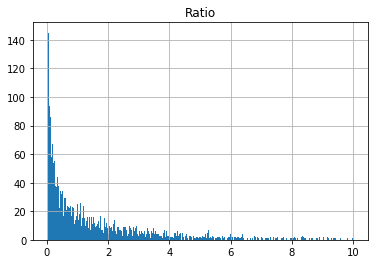

In [25]:
print("percentage of profitable movies: %0.3f" % float((imdb['Ratio']>1).sum() / len(imdb) * 100))
imdb.hist(column="Ratio",bins=1000)
plt.show()

### Most of the movies' rating are around 7

In [26]:
imdb.hist(column="ratings",bins=200)
plt.show()

KeyError: "None of [Index(['ratings'], dtype='object')] are in the [columns]"

### Relation between Rating and whether Profitable

Profitalbe Movies' Average Rating is 6.352 which is slightly higher than unprofitable movies' average rating 6.029

Profitable Movies' Average Rating: 6.352
Unprofitable Movies' Average Rating: 6.029


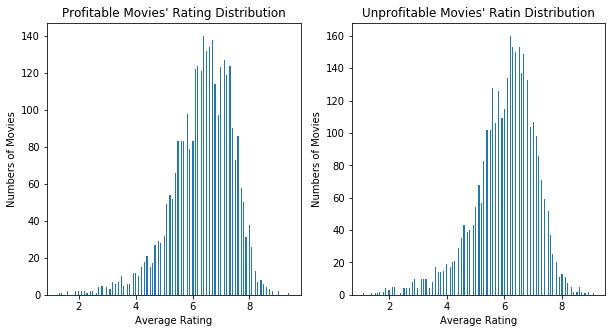

In [15]:
print("Profitable Movies' Average Rating: %.3f" % (imdb[imdb['Ratio']>1]['ratings'].sum() / (imdb['Ratio']>1).sum()))
print("Unprofitable Movies' Average Rating: %.3f" % (imdb[imdb['Ratio']<=1]['ratings'].sum() / (imdb['Ratio']<=1).sum()))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(imdb[imdb['Ratio']>1]['ratings'].to_numpy(),bins=(200))
plt.xlabel("Average Rating")
plt.ylabel("Numbers of Movies")
plt.title("Profitable Movies' Rating Distribution")

plt.subplot(122)
plt.hist(imdb[imdb['Ratio']<1]['ratings'].to_numpy(), bins = 200)
plt.xlabel("Average Rating")
plt.ylabel("Numbers of Movies")
plt.title("Unprofitable Movies' Ratin Distribution")
plt.show()


### Genre and Average Rating

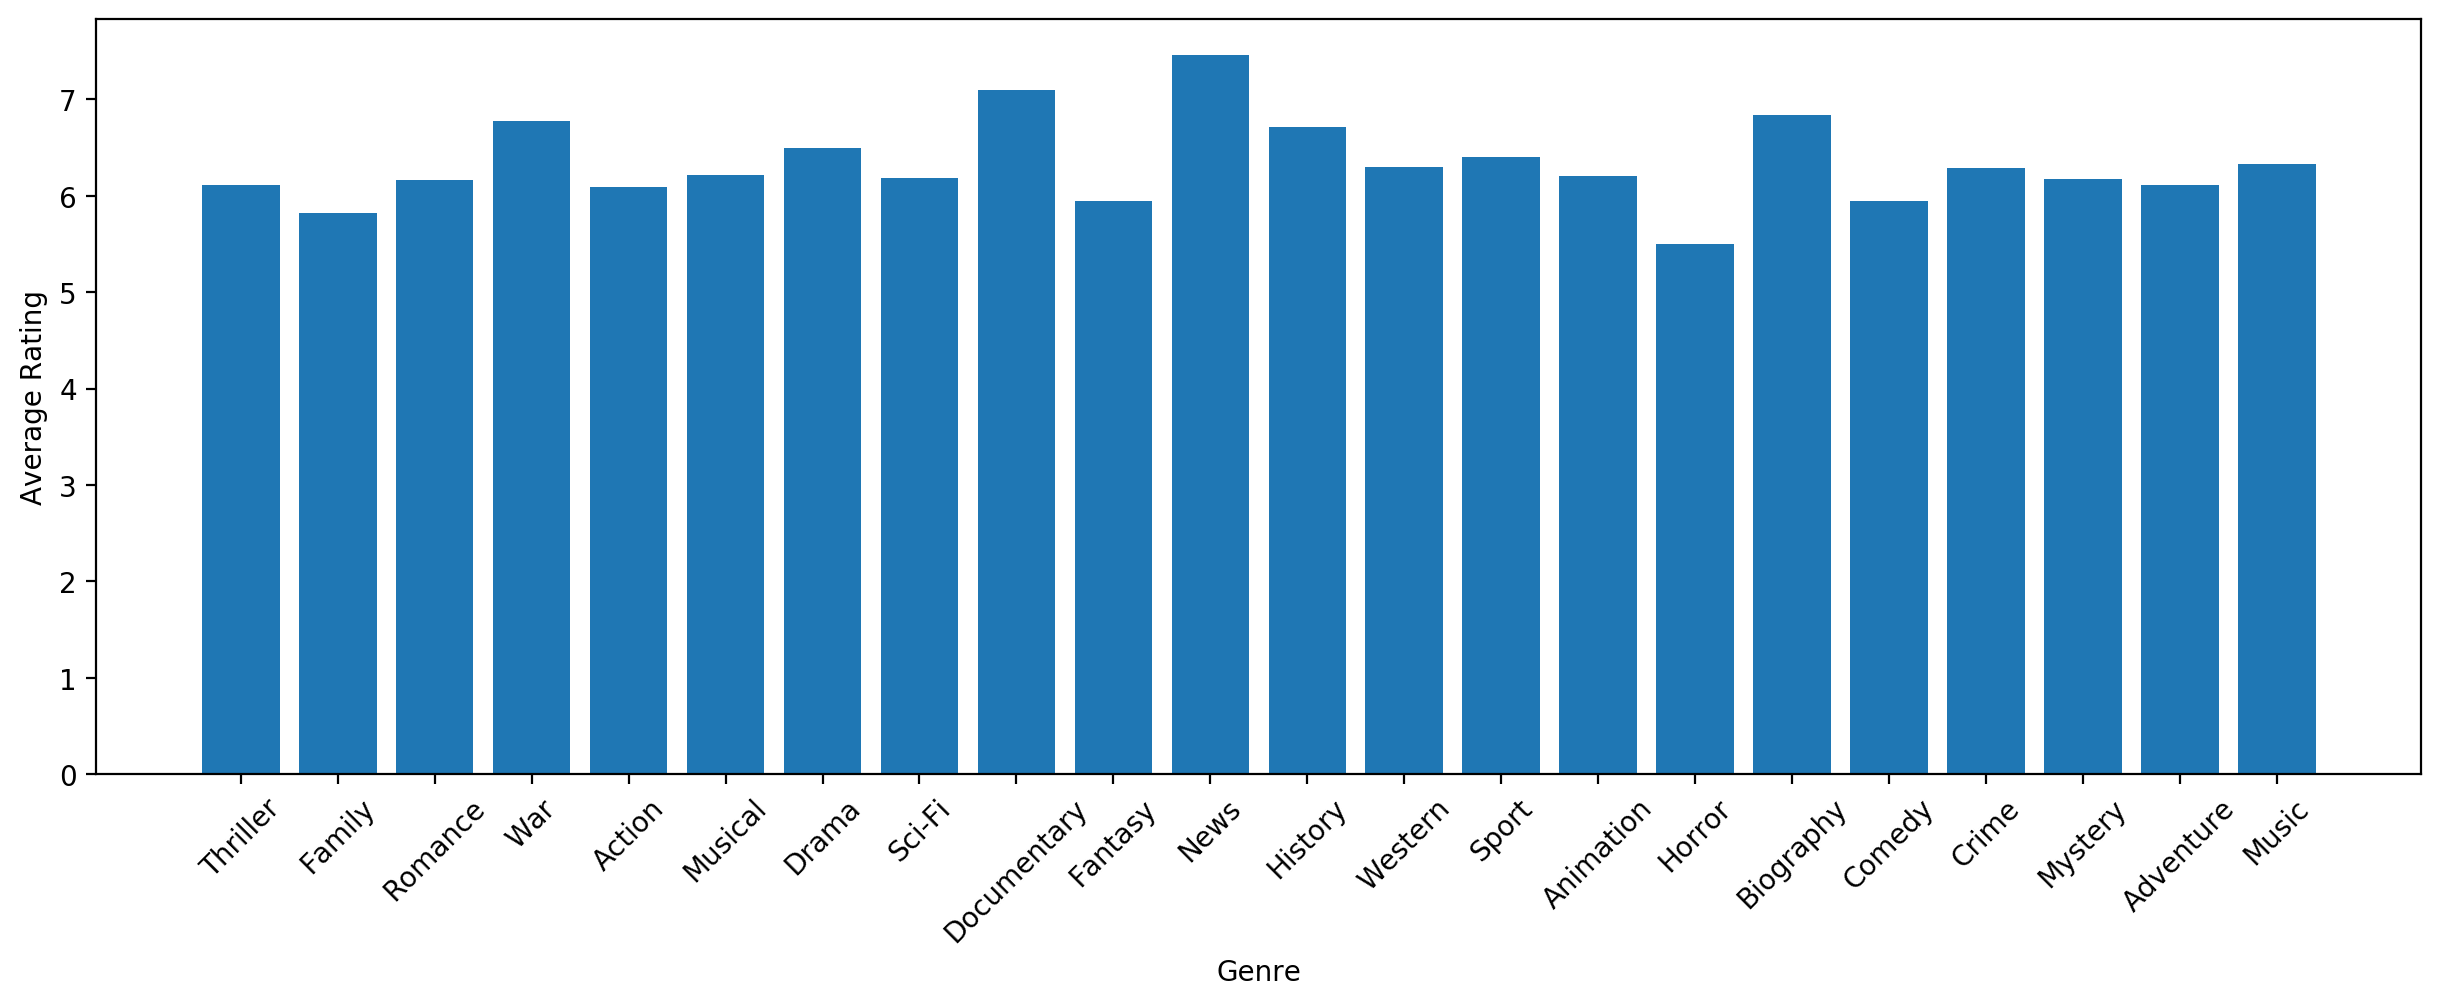

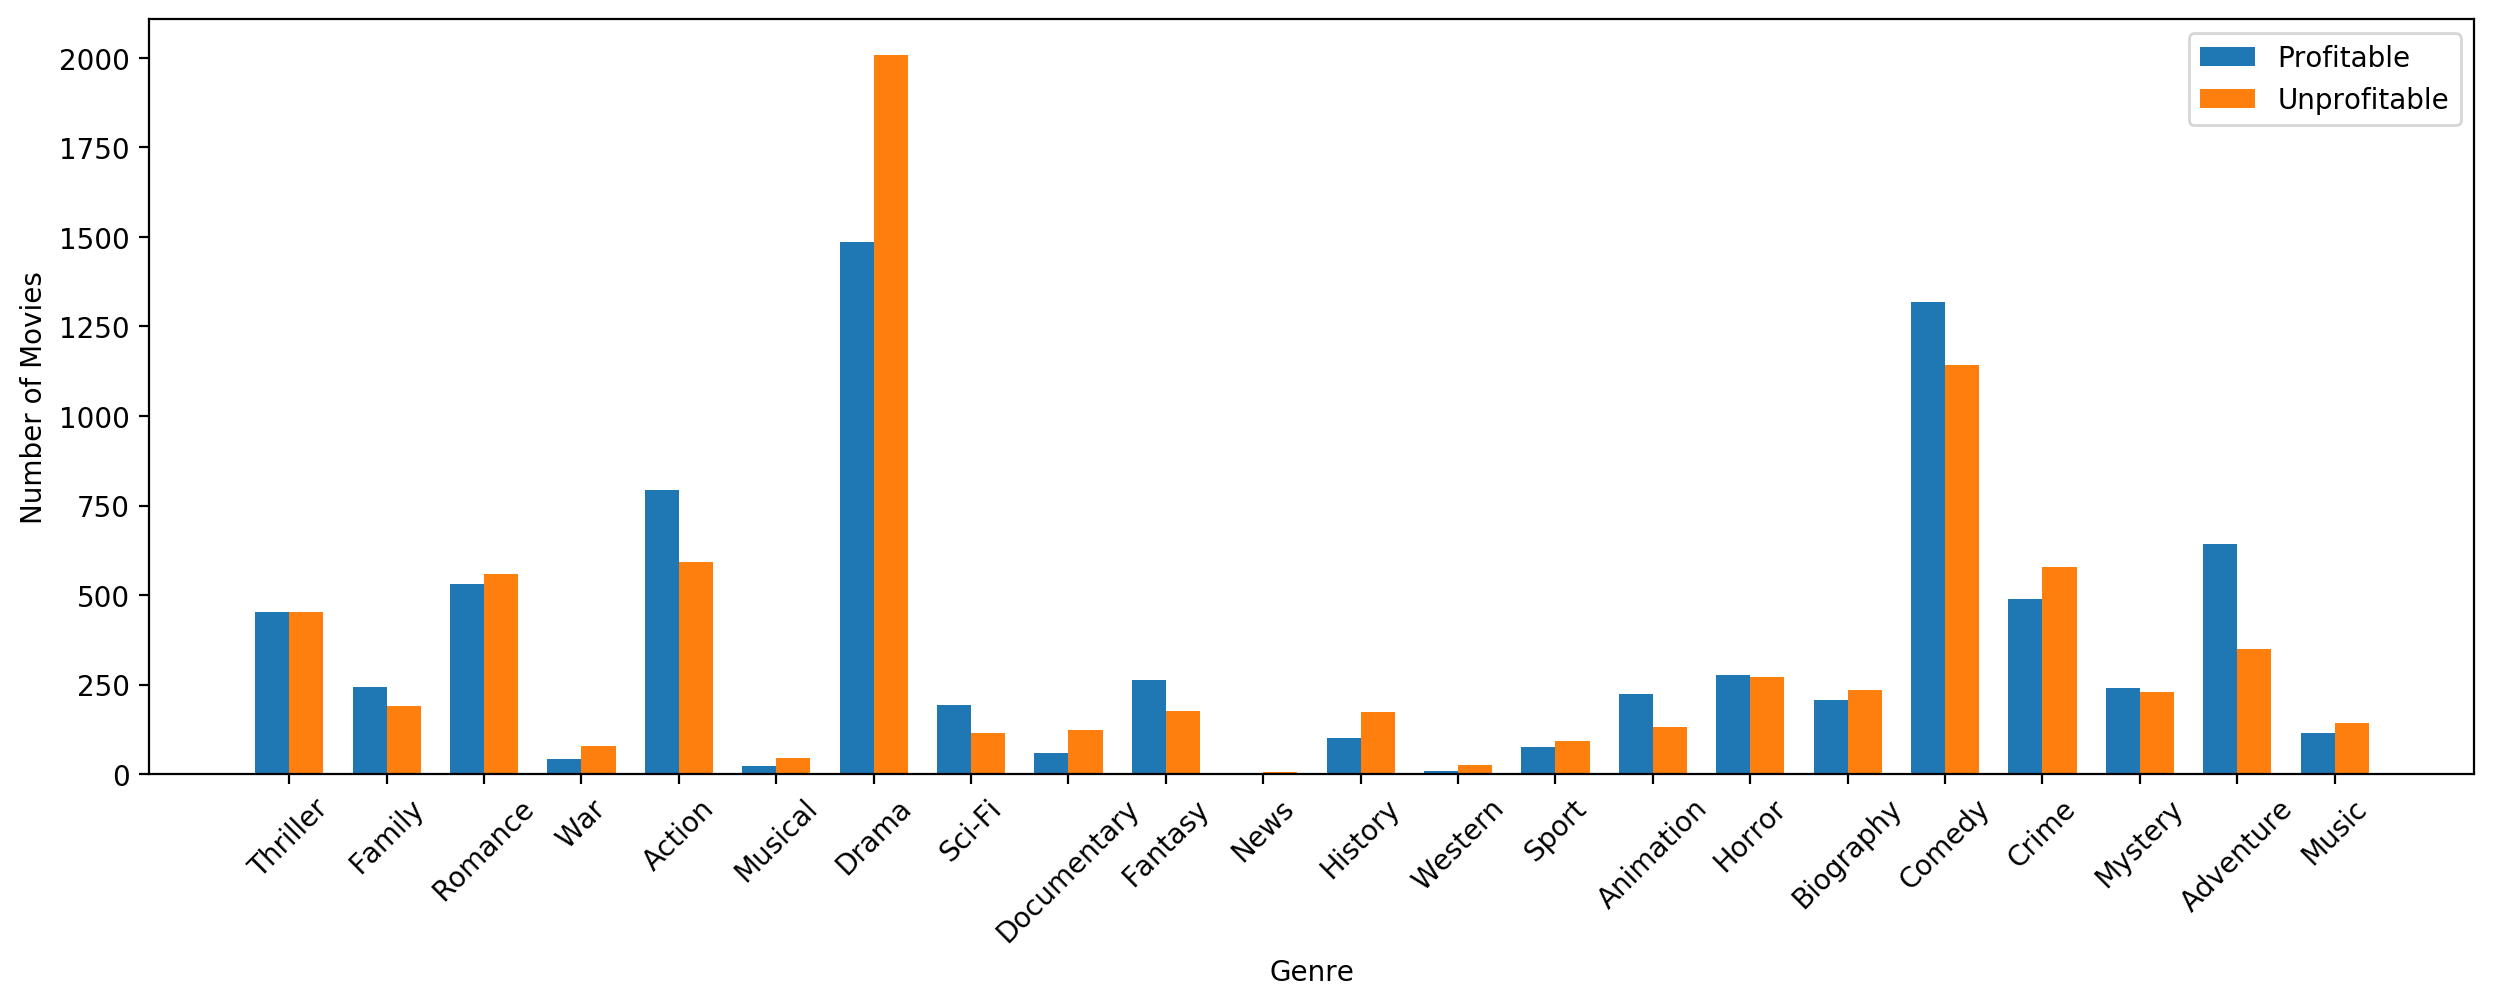

In [16]:
genre_set = set()
for row in imdb.iterrows():
    for each in row[1]['genres'].split(','):
        if each != "\\N":
            genre_set.add(each)
genre_rating_group = {}

for each_genre in genre_set:
    genre_rating = imdb[imdb['genres'].str.contains(each_genre)]['ratings'].sum()
    genre_num = (imdb['genres'].str.contains(each_genre)).sum()
    genre_rating_group[each_genre] = genre_rating / genre_num

plt.figure(dpi=200,figsize=(15,5))
plt.bar(range(len(genre_set)), [genre_rating_group.get(x) for x in genre_set])
plt.xticks(range(len(genre_set)), genre_set, rotation=45)
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.show()

genre_ratio_group = {}
for each_genre in genre_set:
    genre_ratio_positive = imdb[imdb['genres'].str.contains(each_genre)]['Profitable'].sum()
    genre_num = (imdb['genres'].str.contains(each_genre)).sum()
    genre_ratio_negative = genre_num - genre_ratio_positive
    genre_ratio_group[each_genre] = (genre_ratio_positive, genre_ratio_negative)

x = np.arange(len(genre_set))
width = 0.35
plt.figure(dpi=200,figsize=(15,5))
plt.bar(x - width/2, [genre_ratio_group.get(x)[0] for x in genre_set], width, label="Profitable")
plt.bar(x + width/2, [genre_ratio_group.get(x)[1] for x in genre_set], width, label="Unprofitable")
plt.xticks(range(len(genre_set)), genre_set, rotation=45)
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.legend()
plt.show()

### Year and Rating

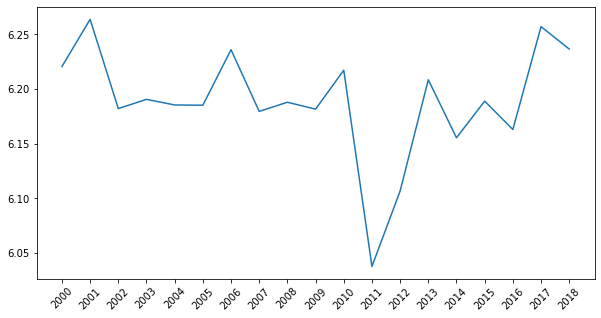

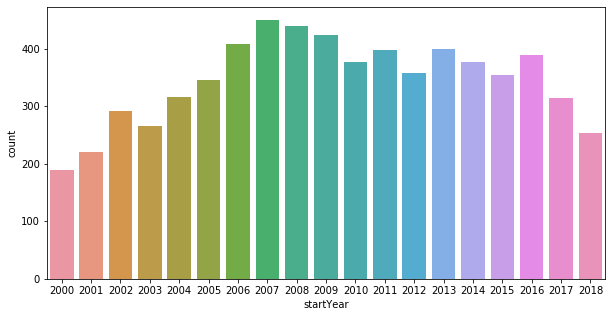

In [18]:
year_rating = []
for year in range(2000,2019):
    rating = imdb[imdb['startYear'] == year]['ratings'].sum() 
    movie_num = (imdb['startYear'] == year).sum()
    rating /= movie_num
    year_rating.append(rating)

plt.figure(figsize=(10,5))
plt.plot(range(2000,2019), year_rating)
plt.xticks(list(range(2000,2019)), rotation=45)
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(x='startYear',data=imdb)
plt.show()

### Run time and Rating

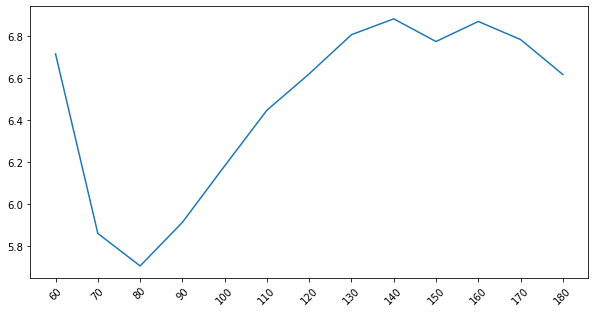

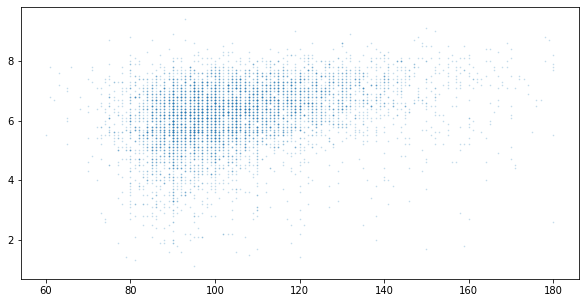

In [20]:
run_time_rating=[]
time_interval = 10
for run_time in range(60,181,time_interval):
    rating = imdb[(imdb['runtimeMinutes'] >= run_time) & (imdb['runtimeMinutes'] < run_time + time_interval)]['ratings'].sum() 
    movie_num = ((imdb['runtimeMinutes'] >= run_time) & (imdb['runtimeMinutes'] < run_time + time_interval)).sum()
    rating /= movie_num
    run_time_rating.append(rating)

plt.figure(figsize=(10,5))
plt.plot(range(60,181,time_interval), run_time_rating)
plt.xticks(list(range(60,181,time_interval)), rotation=45)
plt.show()

plt.figure(figsize=(10,5))   
plt.scatter(imdb['runtimeMinutes'].to_numpy(), imdb['ratings'].to_numpy(), s=0.5,alpha=0.2)
plt.show()

## 3 - Baseline Models

## 4 - Proposed Solutions

## 5 - Results Analysis